# Part 2.2 - Train Final XGBoost model
Use the final training and testing data sets, containing statistical features and timeseries bottleneck features, to train an XGBoost classifier.

In [1]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from termcolor import colored
import matplotlib.pyplot as plt

In [2]:
train_final_gd = gd.from_pandas(pd.read_pickle("train_gdf.pkl"))
test_final_gd = gd.from_pandas(pd.read_pickle("test_gdf.pkl"))

In [3]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,116619873,0,0.0000,0.0000,0.0000,NaN,0.082,65,2.983333,0.033333,...,0.285420,0.925031,7.406346,0.233305,2.419885,3.648186,1.956079,11.332726,0.021425,12.859538
1,116673023,0,0.0000,0.0000,0.0000,NaN,0.038,65,3.200000,0.022222,...,0.801986,0.498845,4.601831,1.305613,0.888614,2.483444,2.155313,8.742307,0.152133,4.563786
2,116679053,0,0.5547,0.5190,0.0163,42.358498,0.032,42,3.152941,0.058824,...,1.241324,3.500375,5.497740,0.093113,5.392372,1.593976,3.090402,3.614620,3.312078,2.549653
3,116697120,0,0.3160,0.2924,0.8410,40.891098,0.077,15,3.139860,0.034965,...,3.911131,2.503263,8.598086,4.952506,7.825676,6.651542,0.828635,0.477027,6.891924,7.729534
4,116704758,0,1.6903,2.0762,0.1813,46.056499,0.102,88,3.042857,0.107143,...,1.444528,2.305176,1.441843,0.056685,4.565281,0.252759,1.588520,7.086769,3.575921,34.985985


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = train_final_gd['target'].to_array()

classes = sorted(np.unique(y))

print(classes)

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [5]:
# Build classes with labels from [0, n-1]
lbl = LabelEncoder()
y = lbl.fit_transform(y)

Set our class weights and build a multi-weighted cross-entropy loss function to train our XGBoost model

In [6]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    Computes the weighted cross-entropy 
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true) # one-hot encodes y_true values
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)

    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)

    # Weight average and divide by the number of positives
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

In [7]:
from functools import partial

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

func_loss = partial(xgb_multi_weighted_logloss, 
                    classes=classes, 
                    class_weights=class_weights)

Preprocess our columns to fill `nan` values with zeros

In [8]:
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

Perform a stratified split of our training dataset into 90% training and 10% validation datasets. 

In [9]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

Set the parameters for XGBoost to build our ensemble of trees   

In [10]:
gpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':0,
            'subsample':0.7,
            'colsample_bytree': 0.7,
            "objective": "multi:softprob",
            "tree_method": "gpu_hist"
}

Build DMatrix objects with our train, validation, and test datasets 

In [11]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)

Train our XGBoost model

In [18]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

clf = xgb.train(gpu_params, 
                dtrain=dtrain,
                num_boost_round=60,
                evals=watchlist,
                feval=func_loss,
                early_stopping_rounds=10,
                verbose_eval=1000)

yp = clf.predict(dvalid)

gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)

ysub = clf.predict(dtest)

line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))

[0]	eval-merror:0.228025	train-merror:0.182784	eval-wloss:1.664	train-wloss:1.60015
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.15414	train-merror:0	eval-wloss:0.668419	train-wloss:0.025191
validation loss 0.6684


In [13]:
y_hat = clf.predict(dvalid)

In [14]:
y_pred = np.argmax(y_hat, axis=1)

Normalized confusion matrix


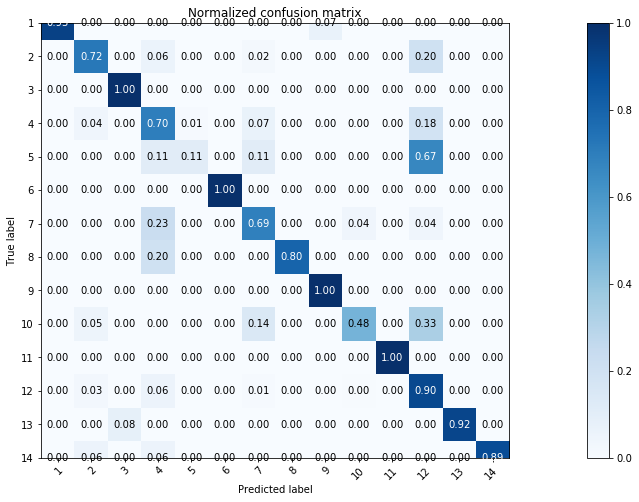

In [15]:
from utils import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred, np.arange(1, len(classes)+1), normalize=True)

## Independent Exercise

Now that you have trained an XGBoost model using both the timeseries embeddings and the statistical features,
1. re-run the previous notebook, but don't merge the timseries features into your training and test datasets before storing them. 
2. Use your new dataset to train a new XGBoost classifier. 
3. Compare the accuracy and confusion matrix against the model that included the timeseries embedding features. 